# Interpretable ML: Traditional Methods and Models (White Box Models)

This notebook will show several methods on models to make Machine Learning interpretable. For now, it will only show intrinsically explainable methods (white-box models), including:

- Regression using linear model, ridge,etc.
- Classifier like decision tree, knn, svm, etc.

Also this notebook will show a little bit introduction on glass-box models (employing black box model with explainability performance like white box model), including:

- Explainable Boosting Models
- SkopeRules

This notebook will refer mostly to **Interpretable Machine Learning with Python Book by Serg Masis.** Specifically for this section, please turn to **Page 60 - 135.**

In [2]:
import pandas as pd
import numpy as np
import regex as re
import math

# has an error with six module from sklearn.external
# need to work around with this code

import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble, neural_network, svm, decomposition, manifold

from rulefit import rulefit

import statsmodels.api as sum

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import matplotlib.pyplot as plt
import seaborn as sns

# from cvae import cvae  # REMIND ME LATER ABOUT THIS LIBRARY
from skrules import SkopeRules

## Dataset Introduction

For this, we will use <a href='https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction'>AirBnb Price Prediction dataset</a>, provided by Steve Zheng.

In [3]:
df = pd.read_csv('/Users/taufiqurrohman/Documents/ds_marketing_portfolio/interpretable_ml/dataset/air-bnb-price.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,74111.0,1.126662e+07,6.081735e+06,344.000000,6.261964e+06,1.225415e+07,1.640226e+07,2.123090e+07
log_price,74111.0,4.782069e+00,7.173938e-01,0.000000,4.317488e+00,4.709530e+00,5.220356e+00,7.600402e+00
accommodates,74111.0,3.155146e+00,2.153589e+00,1.000000,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,73911.0,1.235263e+00,5.820441e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
latitude,74111.0,3.844596e+01,3.080167e+00,33.338905,3.412791e+01,4.066214e+01,4.074610e+01,4.239044e+01
longitude,74111.0,-9.239753e+01,2.170532e+01,-122.511500,-1.183424e+02,-7.699696e+01,-7.395466e+01,-7.098505e+01
number_of_reviews,74111.0,2.090057e+01,3.782864e+01,0.000000,1.000000e+00,6.000000e+00,2.300000e+01,6.050000e+02
review_scores_rating,57389.0,9.406736e+01,7.836556e+00,20.000000,9.200000e+01,9.600000e+01,1.000000e+02,1.000000e+02
bedrooms,74020.0,1.265793e+00,8.521435e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01
beds,73980.0,1.710868e+00,1.254142e+00,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.800000e+01


In [6]:
df.describe(include='object').T

,count,unique,top,freq
property_type,74111,35,Apartment,49003
room_type,74111,3,Entire home/apt,41310
amenities,74111,67122,{},586
bed_type,74111,5,Real Bed,72028
cancellation_policy,74111,5,strict,32374
city,74111,6,NYC,32349
description,74111,73479,"Hello, I've been running guest house for Korea...",8
first_review,58247,2554,2017-01-01,293
host_has_profile_pic,73923,2,t,73697
host_identity_verified,73923,2,t,49748


## Data Cleaning & Pre-Processing

In [7]:
# changing t and f value to true and false

for col in ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']:
    print('before transformation:')
    print('----------------------')
    print(df[col].value_counts())
    
    df[col] = df[col].replace({'t':True, 'f':False})
    df[col] = df[col] == True
    
    print('after transformation:')
    print('----------------------')
    print(df[col].value_counts())

before transformation:
----------------------
t    73697
f      226
Name: host_has_profile_pic, dtype: int64
after transformation:
----------------------
True     73697
False      414
Name: host_has_profile_pic, dtype: int64
before transformation:
----------------------
t    49748
f    24175
Name: host_identity_verified, dtype: int64
after transformation:
----------------------
True     49748
False    24363
Name: host_identity_verified, dtype: int64
before transformation:
----------------------
f    54660
t    19451
Name: instant_bookable, dtype: int64
after transformation:
----------------------
False    54660
True     19451
Name: instant_bookable, dtype: int64


In [8]:
# drop unnecessary columns for analysis

print('length before removing columns:', len(df.columns))
df = df.drop(['description', 'thumbnail_url', 'longitude', 'latitude', 'name', 'zipcode'], axis=1)

print('length after removing columns:', len(df.columns))

length before removing columns: 29
length after removing columns: 23


In [9]:
# dropping column with missing value

print('length before dropping missing value:', len(df))
df = df.dropna()

print('length after dropping missing value:', len(df))

length before dropping missing value: 74111
length after dropping missing value: 43091


In [10]:
# doing a couple of transformation for the date variable
# we're gonna assume that last review is the latest date of the dataset

for col in ['first_review', 'last_review', 'host_since']:
    df[col] = pd.to_datetime(df[col])

bench_date = df['last_review'].max()

df['ds_first_review'] = (bench_date - df['first_review']).dt.days
df['ds_last_review'] = (bench_date - df['last_review']).dt.days
df['ds_host_since'] = (bench_date - df['host_since']).dt.days

df = df.drop(['first_review', 'last_review', 'host_since'], axis=1)

In [11]:
# host response rate cleaning from str to float
# removing the '%' symbol

df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
df['host_response_rate'] = df['host_response_rate'].astype(float) / 100

In [12]:
# cleaning the amenities column
# converting it to list and removing some noises

def amenities_clean(str):
    str = re.sub(r'["{}]', '', str)
    ame_list = str.split(',')
    ame_list = [item for item in ame_list if 'translation missing' not in item]
    return ame_list

df['amenities'] = df['amenities'].map(amenities_clean)

In [13]:
df.reset_index(drop=True, inplace=True)

### Final Check 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43091 entries, 0 to 43090
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      43091 non-null  int64  
 1   log_price               43091 non-null  float64
 2   property_type           43091 non-null  object 
 3   room_type               43091 non-null  object 
 4   amenities               43091 non-null  object 
 5   accommodates            43091 non-null  int64  
 6   bathrooms               43091 non-null  float64
 7   bed_type                43091 non-null  object 
 8   cancellation_policy     43091 non-null  object 
 9   cleaning_fee            43091 non-null  bool   
 10  city                    43091 non-null  object 
 11  host_has_profile_pic    43091 non-null  bool   
 12  host_identity_verified  43091 non-null  bool   
 13  host_response_rate      43091 non-null  float64
 14  instant_bookable        43091 non-null

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,43091.0,1.125083e+07,6.086409e+06,941.0,6.236502e+06,1.223023e+07,1.639336e+07,2.123090e+07
log_price,43091.0,4.772881e+00,6.693324e-01,0.0,4.317488e+00,4.744932e+00,5.192957e+00,7.600402e+00
accommodates,43091.0,3.307790e+00,2.206999e+00,1.0,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,43091.0,1.233912e+00,5.762177e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
host_response_rate,43091.0,9.557583e-01,1.322825e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
number_of_reviews,43091.0,3.172502e+01,4.429875e+01,1.0,5.000000e+00,1.500000e+01,4.000000e+01,5.420000e+02
review_scores_rating,43091.0,9.425184e+01,7.049141e+00,20.0,9.200000e+01,9.600000e+01,9.900000e+01,1.000000e+02
bedrooms,43091.0,1.279130e+00,8.642432e-01,0.0,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01
beds,43091.0,1.790652e+00,1.313377e+00,0.0,1.000000e+00,1.000000e+00,2.000000e+00,1.800000e+01
ds_first_review,43091.0,6.296098e+02,5.241498e+02,0.0,2.400000e+02,4.820000e+02,8.590000e+02,3.180000e+03


In [16]:
# excluding amenities
# will take too long time

df.loc[:, df.columns != 'amenities'].describe(include='object').T

,count,unique,top,freq
property_type,43091,31,Apartment,27862
room_type,43091,3,Entire home/apt,24964
bed_type,43091,5,Real Bed,41892
cancellation_policy,43091,5,strict,22477
city,43091,6,NYC,19397
neighbourhood,43091,590,Williamsburg,1662


In [17]:
df.describe(include='bool').T

,count,unique,top,freq
cleaning_fee,43091,2,True,35513
host_has_profile_pic,43091,2,True,43024
host_identity_verified,43091,2,True,31489
instant_bookable,43091,2,False,30527


In [18]:
df.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,host_response_rate,instant_bookable,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,ds_first_review,ds_last_review,ds_host_since
0,6304928,5.129899,Apartment,Entire home/apt,"[Wireless Internet, Air conditioning, Kitchen,...",7,1.0,Real Bed,strict,True,...,1.0,True,Hell's Kitchen,6,93.0,3.0,3.0,61,12,108
1,7919400,4.976734,Apartment,Entire home/apt,"[TV, Cable TV, Wireless Internet, Air conditio...",5,1.0,Real Bed,moderate,True,...,1.0,True,Harlem,10,92.0,1.0,3.0,158,21,345
2,3808709,4.744932,Apartment,Entire home/apt,"[TV, Internet, Wireless Internet, Air conditio...",2,1.0,Real Bed,moderate,True,...,1.0,True,Columbia Heights,4,40.0,0.0,1.0,877,256,949
3,12422935,4.442651,Apartment,Private room,"[TV, Wireless Internet, Heating, Smoke detecto...",2,1.0,Real Bed,strict,True,...,1.0,True,Noe Valley,3,100.0,1.0,1.0,39,30,120
4,13971273,4.787492,Condominium,Entire home/apt,"[TV, Cable TV, Wireless Internet, Wheelchair a...",2,1.0,Real Bed,moderate,True,...,1.0,False,Downtown,9,93.0,1.0,1.0,293,176,1601


### Data Preparation for the Model

In [19]:
df_model = df.copy(deep=True)       # create duplicate for the model
rand = 42                           # define random state for reproducibility

In [20]:
# changing bool to integer

for col in df_model.columns:
    if df_model[col].dtype == 'bool':
        df_model[col] = df_model[col].astype(int)

In [21]:
# splitting the data bet

y = df_model['log_price']
x = df_model.drop(['id', 'log_price'], axis=1)

# make y for the regression first

x_train, x_test, y_train_reg, y_test_reg = train_test_split(x, y, 
                                                            test_size=0.15, 
                                                            random_state=42)

In [22]:
# create multihotencoder class
# because we have a column that contains list
# https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
# with adjusted for get_feature_names_out() method
 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X: pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:, i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X: pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:, i]))

        result = np.concatenate(result, axis=1)
        return result

    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for i, classes in enumerate(self.classes_):
            if input_features:
                feature_name = input_features[i]
            else:
                feature_name = f'column_{i}'
            for cls in classes:
                feature_names.append(f'{feature_name}_{cls}')
        return feature_names

In [23]:
# one hot encoding for categorical variable
# IMPORTANT NOTES: encoding categorical variable should be done AFTER splitting the data, to avoid data leakage
# learn more: https://www.kaggle.com/code/alexisbcook/data-leakage

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood']

preprocessor = ColumnTransformer(
    transformers=[
        ('multi-hot', MultiHotEncoder(), ['amenities']),
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols),  # set handle unknown to ignore to make it fits to test dataframe
    ],
    remainder='passthrough'
)

x_train = preprocessor.fit_transform(x_train)

In [24]:
# showing the dataframe
# whether we already have a good shape of the data

import pandas as pd
from scipy.sparse import csr_matrix

x_train_df = pd.DataFrame.sparse.from_spmatrix(csr_matrix(x_train), columns=preprocessor.get_feature_names_out())
x_train_df

,multi-hot__amenities_,multi-hot__amenities_ smooth pathway to front door,multi-hot__amenities_24-hour check-in,multi-hot__amenities_Accessible-height bed,multi-hot__amenities_Accessible-height toilet,multi-hot__amenities_Air conditioning,multi-hot__amenities_Air purifier,multi-hot__amenities_BBQ grill,multi-hot__amenities_Baby bath,multi-hot__amenities_Baby monitor,...,remainder__host_identity_verified,remainder__host_response_rate,remainder__instant_bookable,remainder__number_of_reviews,remainder__review_scores_rating,remainder__bedrooms,remainder__beds,remainder__ds_first_review,remainder__ds_last_review,remainder__ds_host_since
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,100.0,1.0,1.0,151.0,151.0,1418.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,14.0,97.0,2.0,2.0,151.0,11.0,172.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,128.0,96.0,1.0,2.0,1195.0,156.0,1234.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,7.0,100.0,1.0,1.0,278.0,238.0,1343.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,5.0,80.0,1.0,1.0,1093.0,759.0,1848.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36622,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,46.0,95.0,1.0,1.0,821.0,32.0,842.0
36623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,7.0,91.0,1.0,1.0,80.0,37.0,88.0
36624,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,44.0,93.0,6.0,6.0,881.0,333.0,2336.0
36625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,6.0,80.0,1.0,1.0,136.0,20.0,152.0


In [25]:
x_test = preprocessor.transform(x_test)

x_test_df = pd.DataFrame.sparse.from_spmatrix(csr_matrix(x_test), columns=preprocessor.get_feature_names_out())
x_test_df

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['Bath towel', 'Body soap', 'Grab-rails for shower and toilet', 'Hand or paper towel', 'Hand soap', 'Toilet paper'] will be ignored
  warnings.warn(


,multi-hot__amenities_,multi-hot__amenities_ smooth pathway to front door,multi-hot__amenities_24-hour check-in,multi-hot__amenities_Accessible-height bed,multi-hot__amenities_Accessible-height toilet,multi-hot__amenities_Air conditioning,multi-hot__amenities_Air purifier,multi-hot__amenities_BBQ grill,multi-hot__amenities_Baby bath,multi-hot__amenities_Baby monitor,...,remainder__host_identity_verified,remainder__host_response_rate,remainder__instant_bookable,remainder__number_of_reviews,remainder__review_scores_rating,remainder__bedrooms,remainder__beds,remainder__ds_first_review,remainder__ds_last_review,remainder__ds_host_since
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.00,0.0,1.0,80.0,0.0,1.0,40.0,40.0,822.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.00,0.0,26.0,98.0,1.0,2.0,452.0,170.0,763.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.00,0.0,6.0,90.0,1.0,1.0,339.0,219.0,997.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.40,0.0,3.0,100.0,2.0,2.0,690.0,646.0,1966.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.00,1.0,10.0,98.0,1.0,1.0,164.0,17.0,795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.67,0.0,4.0,95.0,1.0,2.0,129.0,30.0,1961.0
6460,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.00,0.0,30.0,98.0,0.0,2.0,305.0,10.0,470.0
6461,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.0,25.0,98.0,1.0,2.0,206.0,4.0,862.0
6462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.0,4.0,95.0,1.0,1.0,258.0,18.0,1549.0


In [26]:
# create a new target variable for classification task

avg_price = y_train_reg.mean()

y_train_class = y_train_reg.apply(lambda x: 1 if x > avg_price else 0) 
y_test_class = y_test_reg.apply(lambda x: 1 if x > avg_price else 0) 

# Interpretable Models

## Make the Model

### Regression Model

    1. Make a dictionary of the models for the regression
    
There's a lot of models that we'll pass to the iterator later. See more details about the models on page 70. But something worth to note:

- **Ridge:** Regression with regularitzation with Lasso to overcome overfitting of the OLS method
- **Rule Fit:** Similar to regression, but by expanding the model to include feature interactions in the form of rule
- **Multi-Layer Perception:** The simplest form of neural network using sequential layers, where usually DNN using the tensorflow module

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, tree, neighbors, ensemble, neural_network
from rulefit import RuleFit

# make a dictionary of the models
# will be iterated and passed to our model
# random state is set to 42

reg_models = {
    'linear': {'model': linear_model.LinearRegression()},
    'linear_poly': {'model': make_pipeline(PolynomialFeatures(degree=2), 
                                           linear_model.LinearRegression(fit_intercept=False))
                    },
    'linear_interact': {'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                                               linear_model.LinearRegression(fit_intercept=False))
                        },
    'ridge': {'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])},
    'decision_tree': {'model': tree.DecisionTreeRegressor(max_depth=7,
                                                          random_state=rand)
                      },
    'rulefit': {'model': RuleFit(max_rules=150,  # rulefit created by Cristoph Molnar, not by scikit
                                 rfmode='regress', 
                                 random_state=rand)
                },
    'knn': {'model': neighbors.KNeighborsRegressor(n_neighbors=7)},
    'random_forest': {'model': ensemble.RandomForestRegressor(max_depth=7,  # the larger the tree, it will become better to fit to the data 
                                                              random_state=rand)
                      },
    'mlp': {'model': neural_network.MLPRegressor(hidden_layer_sizes=(21,),  # multi-layer perception
                                                 max_iter=500,
                                                 early_stopping=True,
                                                 random_state=rand)
            }
}

    2. Training and Evaluatig All the Models

In [28]:
from tqdm import tqdm

for model_name in tqdm(reg_models.keys()):
    
    # rulefit has different mechanism compared to scikit modules
    # need to fit the model using array of values
    if model_name == 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(x_train.toarray(),  # the value is in sparse matrix, so we have to convert to array, adjust on your needs
                                                           y_train_reg.values, 
                                                           list(preprocessor.get_feature_names_out()))  # this one for taking the name of the columns
        y_train_pred = fitted_model.predict(x_train.toarray())
        y_test_pred = fitted_model.predict(x_test.toarray())
    
    # else for scikit models
    else:
        fitted_model = reg_models[model_name]['model'].fit(x_train, y_train_reg)
        y_train_pred = fitted_model.predict(x_train)
        y_test_pred = fitted_model.predict(x_test)
        
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['pred'] = y_test_pred
    
    # performance of the model using RMSE and R-squared
    
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)
    
    print('done processing for:', model_name)

 11%|█         | 1/9 [00:00<00:06,  1.33it/s]

done processing for: linear


 22%|██▏       | 2/9 [00:36<02:31, 21.58s/it]

done processing for: linear_poly


 33%|███▎      | 3/9 [01:14<02:54, 29.00s/it]

done processing for: linear_interact


 44%|████▍     | 4/9 [01:20<01:40, 20.01s/it]

done processing for: ridge


 56%|█████▌    | 5/9 [01:21<00:51, 12.99s/it]

done processing for: decision_tree


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e+00, tolerance: 1.637e+00
  model = cd_fast.enet_coordinate_descent(
 67%|██████▋   | 6/9 [01:52<00:57, 19.19s/it]

done processing for: rulefit


 78%|███████▊  | 7/9 [04:04<01:52, 56.01s/it]

done processing for: knn


 89%|████████▉ | 8/9 [04:53<00:53, 53.92s/it]

done processing for: random_forest


100%|██████████| 9/9 [05:01<00:00, 33.45s/it]

done processing for: mlp


In [29]:
# wrap it into a dataframe and show it

reg_eval_df = pd.DataFrame.from_dict(reg_models, orient='index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_eval_df = reg_eval_df.sort_values(by='RMSE_test')

# styling the dataframe

reg_eval_df.style.background_gradient(cmap='viridis', low=0, high=1,
                                      subset=['RMSE_train', 'RMSE_test']).\
                                          background_gradient(cmap='plasma', low=0, high=1,
                                                              subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
ridge,0.327113,0.336302,0.750783
linear,0.328492,0.337509,0.748992
rulefit,0.381822,0.383388,0.676113
random_forest,0.387526,0.395627,0.655103
mlp,0.342875,0.397212,0.652334
decision_tree,0.398017,0.407124,0.634767
linear_interact,0.387534,0.410913,0.627937
linear_poly,0.424868,0.444263,0.565091
knn,0.590514,0.693834,-0.060789


### Classification Model

In [30]:
# check balance of the class

y_train_class.value_counts(normalize=True)

0    0.512737
1    0.487263
Name: log_price, dtype: float64

    1. Fitting and Training the Model

Check the explanation and description of the model on Page 76.

In [31]:
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble, neural_network

class_models = {
    'logistic': {'model': linear_model.LogisticRegression()},
    'ridge': {'model': linear_model.RidgeClassifierCV(cv=5,
                                                      alphas=[1e-3, 1e-2, 1e-1, 1],
                                                      class_weight='balanced'  # IMPORTANT: set this to balanced if you have an imbalanced class
                                                      )},
    'decision_tree': {'model': tree.DecisionTreeClassifier(max_depth=7,
                                                           random_state=rand)
                      },
    'knn': {'model': neighbors.KNeighborsClassifier(n_neighbors=7)
            },
    'naive_bayes': {'model': naive_bayes.GaussianNB()
                    },
    'gradient_boosting': {'model': ensemble.GradientBoostingClassifier(n_estimators=210)
                          },
    'random_forest': {'model': ensemble.RandomForestClassifier(max_depth=11,
                                                               class_weight='balanced',  # IMPORTANT: set this to balanced if you have an imbalanced class
                                                               )},
    'mlp': {'model': make_pipeline(StandardScaler(), 
                                   neural_network.MLPClassifier(hidden_layer_sizes=(7,),
                                                                max_iter=500,
                                                                early_stopping=True,
                                                                random_state=rand))
            }
    }

    2. Evaluating the Model

There's a lot of metrics that you can check on Page 81. But, the most metric worth to mention is:

- **Matthews Correlation Coefficient (MCC):** Ability to produce TP, FN, TN, and FP fairly because it takes into account proportion of classes, which would be optimal for **imbalanced class**.

In [32]:
# change every sparse of matrix to array
# to make it more generally accessible to every model

for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model'].fit(x_train.toarray(), y_train_class)
    y_train_pred = fitted_model.predict(x_train.toarray())
    
    # ridge doesn't have prediction probability
    # while the others have
    
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(x_test.toarray())
    else:
        y_test_prob = fitted_model.predict_proba(x_test.toarray())[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
        
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    
    class_models[model_name]['recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    
    # calculating for roc-auc test
    # all the metrics score below are only applicapble for test data
    
    if model_name == 'ridge':
        class_models[model_name]['roc_auc_test'] = 0
    else:
        class_models[model_name]['roc_auc_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
        
    class_models[model_name]['f1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['mcc_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)
    
    print('done processing for:', model_name)

  0%|          | 0/8 [00:00<?, ?it/s]/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 12%|█▎        | 1/8 [00:02<00:20,  2.93s/it]

done processing for: logistic


 25%|██▌       | 2/8 [00:20<01:08, 11.45s/it]

done processing for: ridge


 38%|███▊      | 3/8 [00:23<00:38,  7.77s/it]

done processing for: decision_tree


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
 50%|█████     | 4/8 [01:26<01:57, 29.30s/it]

done processing for: knn


 62%|██████▎   | 5/8 [01:27<00:57, 19.29s/it]

done processing for: naive_bayes


 75%|███████▌  | 6/8 [07:37<04:36, 138.47s/it]

done processing for: gradient_boosting


 88%|████████▊ | 7/8 [07:53<01:38, 98.37s/it] 

done processing for: random_forest


100%|██████████| 8/8 [08:01<00:00, 60.15s/it]

done processing for: mlp


In [33]:
class_eval_df = pd.DataFrame.from_dict(class_models, orient='index')[['acc_train', 'acc_test', 'recall_train', 'recall_test', 'roc_auc_test', 'f1_test', 'mcc_test']]
class_eval_df = class_eval_df.sort_values(by='roc_auc_test', ascending=False)

# decorating the dataframe

class_eval_df.style.background_gradient(cmap='plasma', low=0.3, high=1,
                                        subset=['acc_train', 'acc_test']).\
                                            background_gradient(cmap='viridis', low=1, high=0.3,
                                                                subset=['recall_train', 'recall_test', 'roc_auc_test', 'f1_test', 'mcc_test'])

,acc_train,acc_test,recall_train,recall_test,roc_auc_test,f1_test,mcc_test
mlp,0.876976,0.852259,0.878579,0.852090,0.925975,0.847322,0.704258
gradient_boosting,0.849455,0.841275,0.858296,0.855305,0.924124,0.838323,0.683084
random_forest,0.832610,0.825031,0.860929,0.856592,0.900368,0.824895,0.652321
decision_tree,0.830508,0.822710,0.834202,0.831833,0.886880,0.818671,0.645639
logistic,0.808993,0.813428,0.846473,0.855305,0.882728,0.815201,0.630477
naive_bayes,0.714637,0.700340,0.854205,0.842444,0.767709,0.730110,0.425160
knn,0.683212,0.532178,0.665882,0.516720,0.549084,0.515229,0.063220
ridge,0.854916,0.847308,0.871015,0.867203,0.000000,0.845322,0.695618


## Interpretation Using Traditional Models

### Linear Regression Model

    Interpretation of the Coefficient and Intercept

In [34]:
# calling intercept and all coefficients from sklearn fitted model

var_list = preprocessor.get_feature_names_out()  # create a list of the predictors from sparse matrix, in forms of array

coef_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_

coef_df = pd.DataFrame({'feature': list(var_list), 'coef': coef_lm}).sort_values('coef', ascending=False)
coef_df.head(25)

,feature,coef
539,encoder__neighbourhood_Noho,1.044275
480,encoder__neighbourhood_Malibu,0.928458
641,encoder__neighbourhood_Soho,0.731601
689,encoder__neighbourhood_Tribeca,0.662853
418,encoder__neighbourhood_Hudson Square,0.641650
396,encoder__neighbourhood_Greenwich Village,0.632411
732,encoder__neighbourhood_West Village,0.619374
355,encoder__neighbourhood_Flatiron District,0.618460
267,encoder__neighbourhood_Chelsea,0.604840
495,encoder__neighbourhood_Meatpacking District,0.603429


    Feature Importance 

- Using t-statistic value
- Not implemented in sklearn, thus we have to rely on statsmodels library

In [35]:
import statsmodels.api as sm

# converting x_train to dataframe first
x_train_df = pd.DataFrame.sparse.from_spmatrix(x_train, columns=var_list)

# training the model using statsmodels
linreg_mdl = sm.OLS(y_train_reg.reset_index(drop=True), sm.add_constant(x_train_df))
linreg_mdl = linreg_mdl.fit()

In [36]:
# accessing table only for the coefficient
summ_df = linreg_mdl.summary2().tables[1]
summ_df = summ_df.drop(['const']).reset_index().rename(columns={'index':'features'})
summ_df['t_abs'] = abs(summ_df['t'])
summ_df = summ_df.sort_values('t_abs', ascending=False)

# showing the dataframe using styler, to color the rows
# only showing top 10 of the important features, from t_abs value
summ_df.head(10).style.background_gradient(cmap='plasma_r', 
                                           low=0, 
                                           high=0.1, 
                                           subset=['P>|t|']).\
    background_gradient(cmap='plasma_r',
                        low=0,
                        high=0.1,
                        subset=['t_abs'])

,features,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
154,encoder__room_type_Entire home/apt,1.052655,0.012760,82.497307,0.000000,1.027645,1.077665,82.497307
155,encoder__room_type_Private room,0.559220,0.012504,44.722644,0.000000,0.534711,0.583728,44.722644
765,remainder__bedrooms,0.148875,0.003362,44.287917,0.000000,0.142286,0.155464,44.287917
756,remainder__accommodates,0.071517,0.001694,42.228356,0.000000,0.068197,0.074836,42.228356
161,encoder__bed_type_Real Bed,0.350038,0.011505,30.425041,0.000000,0.327488,0.372588,30.425041
757,remainder__bathrooms,0.093852,0.004005,23.434942,0.000000,0.086002,0.101701,23.434942
732,encoder__neighbourhood_West Village,0.668795,0.030742,21.754765,0.000000,0.608539,0.729051,21.754765
267,encoder__neighbourhood_Chelsea,0.639723,0.029804,21.464684,0.000000,0.581307,0.698139,21.464684
407,encoder__neighbourhood_Hell's Kitchen,0.576120,0.026892,21.423746,0.000000,0.523412,0.628829,21.423746
172,encoder__city_SF,0.622908,0.030576,20.372397,0.000000,0.562978,0.682838,20.372397


### Ridge Regression

    Interpreting the coefficient

In [37]:
coef_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature': var_list,
                              'coef_linear': coef_lm,
                              'coef_ridge': coef_ridge}).sort_values('coef_ridge', ascending=False)

# styling and showing the dataframe
# show a darker color for the coefficient from either method with higher coefficient

coef_ridge_df.head(15).style.background_gradient(cmap='viridis_r', low=1, high=0.3, axis=1)

,feature,coef_linear,coef_ridge
539,encoder__neighbourhood_Noho,1.044275,0.918994
480,encoder__neighbourhood_Malibu,0.928458,0.895830
641,encoder__neighbourhood_Soho,0.731601,0.736897
355,encoder__neighbourhood_Flatiron District,0.618460,0.655143
689,encoder__neighbourhood_Tribeca,0.662853,0.632369
732,encoder__neighbourhood_West Village,0.619374,0.631170
396,encoder__neighbourhood_Greenwich Village,0.632411,0.616074
540,encoder__neighbourhood_Nolita,0.601969,0.605688
267,encoder__neighbourhood_Chelsea,0.604840,0.602414
418,encoder__neighbourhood_Hudson Square,0.641650,0.599652


    Feature Importance
    
The way to do is the same with the previous one. We could instead use statsmodels library using **fit_regularized** method.

### Polynomial Regression

In [38]:
# using get_params()
# as we train the data for this one using pipeline

coef_linear_poly = reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_
print(coef_linear_poly)
print('total of coefficients produced:', coef_linear_poly.shape[0])

[ 3.12259076e-05  2.40986824e-07  4.49803996e-07 ...  1.10527331e-07
 -2.55729857e-07 -5.93591941e-08]
total of coefficients produced: 297606


From here, we couldn't see the column names as it is produced automatically

### Logistic Regression

In [39]:
coef_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_

print('coefficient:', coef_log)
print('intercept:', intercept_log)

coefficient: [[ 8.36136973e-05  7.27867235e-03  9.52577620e-02  4.02673477e-03
   2.63293446e-03 -9.54630526e-02 -8.10380625e-04  9.60502541e-03
  -4.48934698e-04  1.61899967e-03  7.66855233e-03  2.26504737e-02
  -1.88351951e-04 -2.89712074e-04 -1.82008263e-03  3.68078694e-02
  -6.62479553e-02  1.65820664e-01  3.27728358e-01 -2.05653019e-02
  -9.06061857e-02  3.02424774e-03  4.99657954e-03  3.30665216e-03
   1.56086838e-03  5.29924247e-02  3.66347550e-02  1.12989926e-02
  -5.32760251e-04  5.07450472e-02  6.90877625e-02 -6.92380033e-02
   1.56724174e-01  2.54492430e-03  1.21460089e-01  2.23789696e-04
   2.34452872e-01  1.24111540e-02 -2.96569811e-02  1.85844327e-02
   3.40185845e-02  1.37089899e-01 -7.21132318e-02  5.38155589e-03
   5.02997397e-04  4.29693813e-04 -1.93472202e-01 -4.69870614e-05
   7.27867235e-03 -5.48313972e-05 -2.23280844e-01 -4.91845584e-03
   1.15700821e-03  1.08013212e-02 -1.14844866e-04  1.40469000e-01
   1.05097332e-01  1.44199021e-03 -1.67391693e-02 -1.46782009e-

    Feature Importance

There's a lot of methods ranging from:
- Standardize all features first
- Pseudo R2 method
- One-feature-at-a-time ROC AUC
- Partial chi-squared statistic method
- etc.

But the **most popular method is to standardize all the features before training.** This is done by:

1. Calculating the standard deviation of each feature
2. Multiplying it to the coefficients

In [40]:
stdv = np.std(x_train.toarray(), axis=0)        # calculating standard deviation of each features
feat_log = abs(coef_log.reshape(770) * stdv)    # reshape the coefficients, then multiply by its stdv

summ_df = pd.DataFrame({'features': var_list, 
                        'feat_log': feat_log}).sort_values('feat_log', ascending=False)

summ_df.head(15).style.background_gradient(cmap='viridis_r',
                                           low=1, 
                                           high=0.3)

,features,feat_log
756,remainder__accommodates,0.957950
154,encoder__room_type_Entire home/apt,0.515064
155,encoder__room_type_Private room,0.487571
766,remainder__beds,0.200906
763,remainder__number_of_reviews,0.167597
18,multi-hot__amenities_Cable TV,0.158544
72,multi-hot__amenities_Lock on bedroom door,0.141918
108,multi-hot__amenities_TV,0.136921
764,remainder__review_scores_rating,0.132775
765,remainder__bedrooms,0.107932


### Decision Trees (Using Classification and Regression Trees (CART))

    Generate the Decision Tree Graph Using Plot

/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_6268/3405093616.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


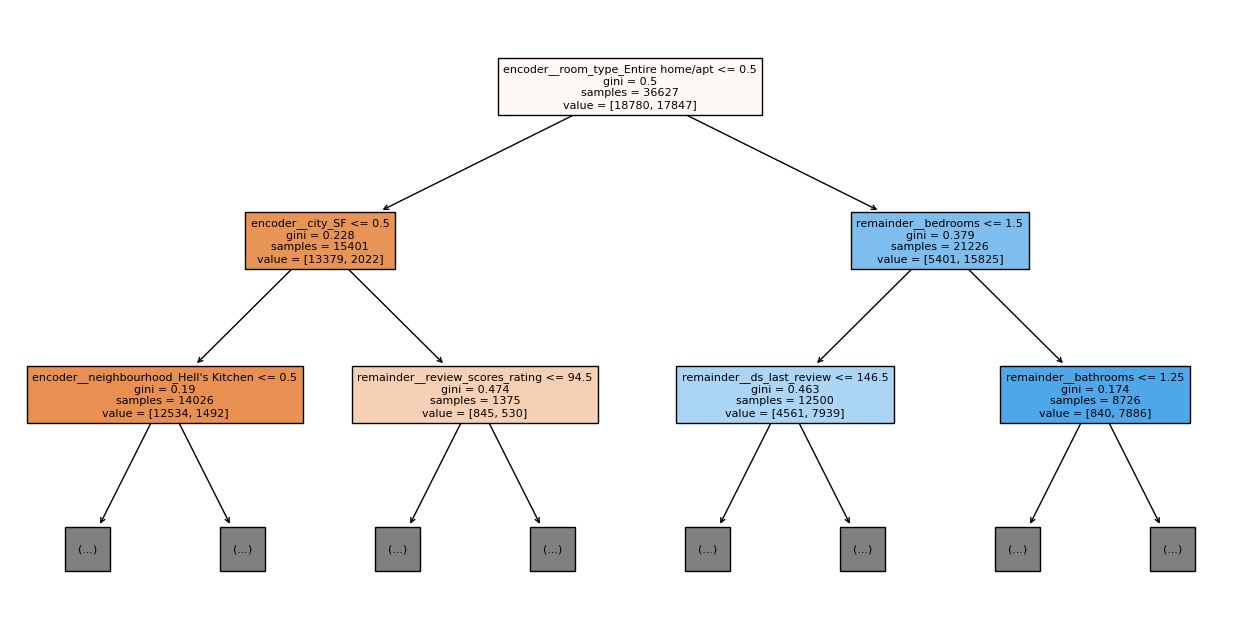

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# calling the plot_three method from tree library (sklearn)
# setting up on the max_depth = 2 as decision tree becomes more complex once you reach the 5th or 6th depth

tree.plot_tree(class_models['decision_tree']['fitted'],
               feature_names=var_list,
               filled=True,
               fontsize=8,  # set to make it bigger
               max_depth=2  # set the depth, how deep we want to look at
               )

fig.show()

    Calculating Feature Importance

- Feature importance in Decision Tree is weighted by how much they contributed to the overall reduction in Gini index compared to previous node. 
- In scikit-learn library, this is already provided by calling **feature_importances_** method.

In [42]:
df_temp = pd.DataFrame({'feature': var_list, 
                        'importance_level': class_models['decision_tree']['fitted'].feature_importances_}).\
                            sort_values('importance_level', ascending=False)
                            
round(df_temp.head(10), 3)

,feature,importance_level
154,encoder__room_type_Entire home/apt,0.729
765,remainder__bedrooms,0.091
768,remainder__ds_last_review,0.036
172,encoder__city_SF,0.022
756,remainder__accommodates,0.016
18,multi-hot__amenities_Cable TV,0.015
764,remainder__review_scores_rating,0.008
171,encoder__city_NYC,0.008
757,remainder__bathrooms,0.008
407,encoder__neighbourhood_Hell's Kitchen,0.006


### RuleFit

- A hybrid model between a LASSO linear regression,
- Get regularized coefficients for every feature using LASSO,
- Merges this with decision rules.

In [43]:
df_temp = reg_models['rulefit']['fitted'].get_rules()  # generate the feature importance by calling get_rules() method 
df_temp = df_temp[df_temp['coef'] != 0].\
    sort_values('importance', ascending=False)
    
df_temp.head(10)

,rule,type,coef,support,importance
154,encoder__room_type_Entire home/apt,linear,0.349116,1.000000,0.172337
756,remainder__accommodates,linear,0.070590,1.000000,0.136309
802,encoder__room_type_Entire home/apt <= 0.5 & en...,rule,-0.197642,0.381410,0.096001
168,encoder__city_Chicago,linear,-0.333304,1.000000,0.078347
798,encoder__room_type_Entire home/apt <= 0.5 & en...,rule,-0.494461,0.021635,0.071938
170,encoder__city_LA,linear,-0.156874,1.000000,0.069813
172,encoder__city_SF,linear,0.207140,1.000000,0.060182
779,remainder__bathrooms > 1.25 & encoder__room_ty...,rule,0.166328,0.129006,0.055754
825,encoder__room_type_Entire home/apt > 0.5 & rem...,rule,0.181766,0.089744,0.051951
764,remainder__review_scores_rating,linear,0.009058,1.000000,0.049822


### Naive Bayes

- Based on Bayes' Theorem of Conditional Probability
- Only for classifier, as the output resulting in probability of each class
- **Strong assumption!** Each feature impacting the target independently, which most likely not the case

In [44]:
# prior distribution of the class
# equal to the proportion between A & B from the training data

class_models['naive_bayes']['fitted'].class_prior_

array([0.51273651, 0.48726349])

In [45]:
# extract sigma_, which means the variance of all features

class_models['naive_bayes']['fitted'].sigma_

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


array([[2.37522000e-03, 6.65318037e-03, 1.87160688e-01, ...,
        2.61377374e+05, 2.76122897e+04, 4.54642398e+05],
       [1.74903289e-03, 1.03361528e-02, 2.36117581e-01, ...,
        2.85723777e+05, 3.46502819e+04, 4.65132657e+05]])

In [46]:
# extract theta_, which means the mean of all features

class_models['naive_bayes']['fitted'].theta_

array([[1.91693291e-03, 6.23003195e-03, 2.48402556e-01, ...,
        6.00395847e+02, 1.38107721e+02, 1.17377279e+03],
       [1.28873200e-03, 9.97366504e-03, 3.80231972e-01, ...,
        6.56557629e+02, 1.40780860e+02, 1.26777783e+03]])

In [47]:
# printing the shape
# resulting in 2, 770
# it means that the fitted model of naive bayes has 2 classes and 770 features in total

print(class_models['naive_bayes']['fitted'].sigma_.shape)
print(class_models['naive_bayes']['fitted'].theta_.shape)

(2, 770)
(2, 770)


To debug and interpret Naive Bayes results using theta_ and sigma_, you can consider the following:

- **Feature Importance:** Look at the magnitude of the mean values in theta_ across classes. Features with larger differences in means between classes are likely to be more discriminative and influential in classification.
- **Feature Distribution:** Examine the variances in sigma_ to understand the spread of feature values within each class. Higher variances might suggest features with more informative or discriminatory power.
- **Feature Selection:** You can use theta_ and sigma_ to identify features that have very low variances (close to zero) within classes. These features have limited discriminatory power and may be candidates for removal or further investigation.



In [48]:
# calculating feature importance using the difference of the mean

nb_sigma = class_models['naive_bayes']['fitted'].sigma_
nb_theta = class_models['naive_bayes']['fitted'].theta_

theta_df = pd.DataFrame({'features': var_list,
                         'mean_0': nb_theta[0],
                         'mean_1': nb_theta[1]})

theta_df['diff'] = theta_df['mean_1'] - theta_df['mean_0']
theta_df.sort_values('diff', ascending=False).head(15)

,features,mean_0,mean_1,diff
769,remainder__ds_host_since,1173.772790,1267.777834,94.005044
767,remainder__ds_first_review,600.395847,656.557629,56.161782
768,remainder__ds_last_review,138.107721,140.780860,2.673139
756,remainder__accommodates,2.327316,4.331764,2.004448
766,remainder__beds,1.337167,2.264022,0.926855
764,remainder__review_scores_rating,93.857934,94.675800,0.817866
765,remainder__bedrooms,0.984079,1.586485,0.602406
154,encoder__room_type_Entire home/apt,0.287593,0.886704,0.599110
41,multi-hot__amenities_Family/kid friendly,0.402769,0.670477,0.267708
757,remainder__bathrooms,1.126731,1.346585,0.219854


# Glass-box Model

- Models that have enough complexity to find the balance between underfitting and overfitting, 
- But still have an adequate level of explainability, not like black box models (deep learning for instance).

### Explainable Boosting Machine (EBM)

From the documentation: 
- Explainable Boosting Machine (EBM) is a tree-based, cyclic gradient boosting Generalized Additive Model with automatic interaction detection. 
- EBMs are often as accurate as state-of-the-art blackbox models while remaining completely interpretable. 
- Although EBMs are often slower to train than other modern algorithms, EBMs are extremely compact and fast at prediction time.

    Training the Model

In [55]:
# as it takes quite long time to train the EBM Model
# sampling the data

np.random.seed(rand)

# generating index for the sample from x_train

sample2_size = 0.1
sample2_idx = np.random.choice(x_train.shape[0],
                               math.ceil(x_train.shape[0] * sample2_size),
                               replace=False)

sample2_idx

array([33688, 30243, 32068, ...,  1418, 12551,   780])

In [71]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(x_train.toarray()[sample2_idx],     # sparse convert to array first to be able to get by indices
            y_train_class.iloc[sample2_idx])   

ExplainableBoostingClassifier()

In [95]:
# this code should be working
# but because it uses dash to plot, it couldn't 

from interpret import show

show(ebm_mdl.explain_global())

ModuleNotFoundError: No module named 'gevent'

See other explanation in their documentation <a href='https://interpret.ml/docs/ebm.html'>here</a>, including:

- Local explanation method
- Performance using AUC ROC

### Skoped Rules

- Another glass-box model, by finding logical rules with high precision and fuse them. 
- Finding good rules is done by fitting classification and regression trees to sub-samples (ensemble of trees). 
- Good for imbalanced datasets as its focusing on precision and recall.

In [130]:
from skrules import SkopeRules

sr_mdl = SkopeRules(n_estimators=200,       # number of decision trees
                    precision_min=0.2,
                    recall_min=0.01,
                    n_jobs=-1,              # leverage all cores
                    random_state=rand,
                    max_depth=7,
                    feature_names=var_list)

sr_mdl.fit(x_train.toarray()[sample2_idx],
           y_train_class.iloc[sample2_idx].values)

SkopeRules(feature_names=array(['multi-hot__amenities_',
       'multi-hot__amenities_ smooth pathway to front door',
       'multi-hot__amenities_24-hour check-in',
       'multi-hot__amenities_Accessible-height bed',
       'multi-hot__amenities_Accessible-height toilet',
       'multi-hot__amenities_Air conditioning',
       'multi-hot__amenities_Air purifier',
       'multi-hot__amenities_BBQ grill', 'multi-hot...
       'remainder__host_identity_verified',
       'remainder__host_response_rate', 'remainder__instant_bookable',
       'remainder__number_of_reviews', 'remainder__review_scores_rating',
       'remainder__bedrooms', 'remainder__beds',
       'remainder__ds_first_review', 'remainder__ds_last_review',
       'remainder__ds_host_since'], dtype=object),
           max_depth=7, n_estimators=200, n_jobs=-1, precision_min=0.2,
           random_state=42)

In [141]:
# print top 5 rules
# to decide if an accomodation price is higher than average

sr_mdl.rules_[:5]

[('encoder__room_type_Entire home/apt > 0.5 and encoder__neighbourhood_Astoria <= 0.5 and encoder__neighbourhood_Bushwick <= 0.5 and encoder__neighbourhood_East Harlem <= 0.5 and encoder__neighbourhood_Sunnyside <= 0.5 and remainder__bedrooms <= 1.5 and remainder__ds_last_review <= 147.0',
  (0.8236514522821576, 0.27997179125528915, 2)),
 ('encoder__room_type_Entire home/apt > 0.5 and encoder__neighbourhood_Astoria <= 0.5 and encoder__neighbourhood_Flatbush <= 0.5 and encoder__neighbourhood_Ridgewood <= 0.5 and encoder__neighbourhood_Sunnyside <= 0.5 and remainder__bedrooms <= 1.5 and remainder__ds_last_review <= 125.5',
  (0.8049281314168378, 0.2808022922636103, 2)),
 ('encoder__room_type_Entire home/apt > 0.5 and encoder__neighbourhood_Astoria <= 0.5 and encoder__neighbourhood_Bushwick <= 0.5 and encoder__neighbourhood_East Harlem <= 0.5 and multi-hot__amenities_Hot water kettle <= 0.5 and remainder__bedrooms <= 1.5 and remainder__ds_last_review <= 150.5',
  (0.8008640696228762, 0.27

    Need to take a look into this code again later, as it produces weird result for the predicition

In [132]:
# access the probability prediction using score_top_rules() method
# then use it to make a prediction

sr_y_test_prob = sr_mdl.score_top_rules(x_test.toarray())
sr_y_test_pred = np.where(sr_y_test_prob > 0.5, 1, 0)

sr_y_test_pred, sr_y_test_prob

(array([1, 1, 1, ..., 1, 1, 1]),
 array([ 745., 1491., 1499., ..., 1854.,  922., 1805.]))

    New things, %.4g for converting number into string and rounding the number

In [155]:
print('accuracy: %.4g' % metrics.accuracy_score(y_test_class, sr_y_test_pred))
print(f'accuracy: {round(metrics.accuracy_score(y_test_class, sr_y_test_pred), 4)}')

accuracy: 0.6371
accuracy: 0.6371


In [166]:
print('accuracy: %.3g \nrecall: %.3g \nroc_auc %.3g \nf1 %.3g \nmcc: %.3g' % (
    metrics.accuracy_score(y_test_class, sr_y_test_pred),
    metrics.recall_score(y_test_class, sr_y_test_pred),
    metrics.roc_auc_score(y_test_class, sr_y_test_pred),
    metrics.f1_score(y_test_class, sr_y_test_pred),
    metrics.matthews_corrcoef(y_test_class, sr_y_test_pred)
    ))

accuracy: 0.637 
recall: 0.982 
roc_auc 0.65 
f1 0.723 
mcc: 0.395


## All-in-All: Limitation of Traditional Methods for Interpret Models

- Most of this model have strong assumptions (e.g Normality, Multicollinearity, etc.) to be met before becoming a robust model
- White-models usually have a worse performance compared to the black box models